In [1]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt

In [9]:
rm = pv.ResourceManager()


In [12]:
recursos = rm.list_resources('?*')
print(recursos) #('ASRL1::INSTR', 'ASRL10::INSTR')
print(rm)
eLoad = rm.open_resource(recursos[1])

('ASRL1::INSTR', 'ASRL8::INSTR')
Resource Manager of Visa Library at C:\Windows\system32\visa32.dll


In [13]:
eLoad.close()

In [11]:
print(eLoad.query('*IDN?'))


VisaIOError: VI_ERROR_CONN_LOST (-1073807194): The connection for the given session has been lost.

In [14]:
eLoad.write("CURR:LEV 0,2")

14

In [15]:
eLoad.query_ascii_values('STATus:OPERation:CONDition?')

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [24]:
while True:
    msg = input("comando Scpi: (q->Query_ascii w-> Write r -> Read) \n")
    if msg.lower() == 'q':
        ins = input("Query ascii : ")
        eLoad.query_ascii_values(ins)
        
    elif msg.lower() == 'w':
        ins = input("Write : ")
        eLoad.write(ins)
        
    
    elif msg.lower() == 'r':
        ins = input("Read : ")
        eLoad.read(ins)
    else:
        break

    

comando Scpi: (q->Query_ascii w-> Write r -> Read) 



In [16]:
eLoad.write('[SOURce:]LIST:REPeat 1')
scpi = ['[SOURce:]LIST:REPeat 1','[SOURce:]LIST:STEP 10','[SOURce:] LIST:MODE CONT','[SOURce:]LIST:SET01:MODE 0',
      ]
for ins in scpi:
    eLoad.write(ins)


In [17]:
eLoad.query_ascii_values('MODE?')

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [135]:
eLoad.write('LIST:CALL 10')
eLoad.query_ascii_values('MEAS:VOLT?')

[11.5036]

In [105]:
reset()
remote()
eLoad.write('SOURce:VOLTage:LEVel:IMMediate:AMPLitude 10')

45

In [16]:
######## FUNCIONES RÁPIDAS
def run(el=eLoad):
    el.write('INPUT:ON')
    
def stop(el=eLoad):
    el.write('INPUT:OFF')
    
def medir (mag,el = eLoad):
    """Lee el valor de la mediciín opciones: VOLT|CURR|POW.
    Para más opciones revisar el manuel de scpi."""
    return el.query_ascii_values(f'MEAS:{mag}?')[0]
    
def local(el=eLoad):
    el.write('SYST:LOC')

def remote(el=eLoad):
    el.write('SYST:REM')

def reset(el=eLoad):
    el.write('*RST')

def mode(el=eLoad):
    modo = el.query_ascii_values('MODE?')[0]
    
    if modo == 0:
        return "Constant Current"
    if modo == 1:
        return "Constant Voltage"
    if modo == 3:
        return "Constant Power"
    if modo == 4:
        return "Dynamic operation mode"
    if modo == 5:
        return "Dynamic voltage mode"
    if modo == 10:
        return "OCP mode"
    if modo == 11:
        return "OPP mode"
    if modo == 12:
        return "Battery CC discharge mode"
    if modo == 13:
        return "Battery CR discharge mode"
    if modo == 14:
        return "Battery CP discharge mod"
    if modo == 18:
        return "List mode"
    if modo == 20:
        return "LED mode"
    if modo == 21:
        return "Time test"
    if modo == 23:
        return "OVP mode"
    return 'CR or Error'

    

In [241]:
run()
time.sleep(0.5)
print("voltaje : " , medir('VOLT')," V")
time.sleep(0.5)
print("Corriente : ",medir('CURR')," A")
time.sleep(0.5)
print("Potencia : ",medir('POW'), " W")
time.sleep(0.5)

#stop()

voltaje :  11.4887  V
Corriente :  0.0  A
Potencia :  0.0  W


In [17]:
eLoad.write('QCModule: PROTocol QC2')
time.sleep(0.5)

eLoad.write('QCModule:CONN?')
time.sleep(0.5)

eLoad.write('MODE CURR')
time.sleep(0.5)

eLoad.write('CURR 1A')
time.sleep(0.5)

eLoad.write('INPUT ON')
print("voltaje : " , medir('VOLT')," V")
time.sleep(0.5)

print("Corriente : ",medir('CURR')," A")
time.sleep(0.5)

print("Potencia : ",medir('POW'), " W")
time.sleep(1.5)

eLoad.write('CURR 0.5A')
time.sleep(0.5)

eLoad.write('INPUT ON')
print("voltaje : " , medir('VOLT')," V")
time.sleep(0.5)

print("Corriente : ",medir('CURR')," A")
time.sleep(0.5)

print("Potencia : ",medir('POW'), " W")
time.sleep(1.5)

eLoad.write('INPUT OFF')
time.sleep(0.5)
eLoad.write('QCM:PROT NULL')

voltaje :  12.5087  V
Corriente :  0.9993  A
Potencia :  12.1767  W
voltaje :  12.2618  V
Corriente :  0.5  A
Potencia :  6.1305  W


15

In [292]:
def iv(start,stop,num,mode = 'CURR',el=eLoad,graph=1):
    """Función para levantar curvas IV automaticamente. Por default el modo es
    corriente constante para hacerlo a voltaje constante modo=VOLT"""
    # POR AHORA USAR TIME.SLEEP OJO!
    test_points = np.linspace(start,stop,num)
    voltaje = []
    corriente = []
    
    #Selección de protocolo cargado rápido ¿?
    el.write('QCModule: PROTocol QC2')
    time.sleep(0.5)
    
    #Confirmación de comunicación establecida 
    el.write('QCModule:CONN?')
    time.sleep(0.5)
    
    #Selección de modo
    el.write(f'MODE {mode}')
    time.sleep(0.5)
    
    off = True
    #Inicio de las mediciones
    for point in test_points:
        #print(f'{modo} {point:.4f}')
        el.write(f'{mode} {point:.4f}')
        time.sleep(0.7)
        
        if not eLoad.query_ascii_values('INPUT?')[0]:
            el.write('INPUT ON')
            
       
        
        voltaje.append(medir('VOLT'))
        time.sleep(0.5)

        corriente.append(medir('CURR'))
        time.sleep(0.5)
        
    el.write('INPUT OFF')
    
    if graph:
        plotiv(corriente,voltaje)
    
    return (voltaje,corriente)
        
def plotiv(cor,volt):
    plt.scatter(x=cor,y=volt)
    plt.xlabel('Corriente [A]')
    plt.ylabel('Voltaje [V]')
    plt.title('Curva IV')
    plt.xlim((0,5))
    plt.ylim((0,14))

    
    
    


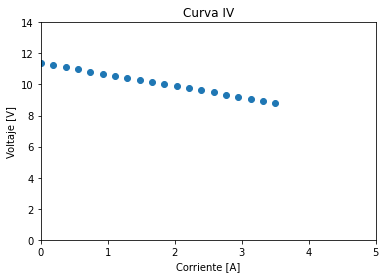

In [296]:
volt,cor = iv(0,3.5,20)

([11.44,
  8.44,
  8.8883,
  9.3316,
  9.7774,
  10.2208,
  10.6666,
  11.1099,
  11.3316,
  11.3513],
 [5.4985, 4.4591, 3.6498, 2.9011, 2.1987, 1.5287, 0.8889, 0.2874, 0.0, 0.0])

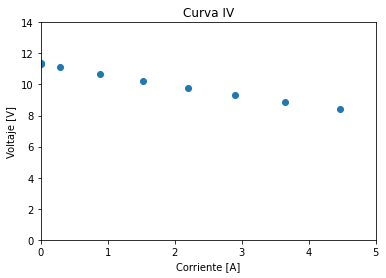

In [294]:
iv(8,12,10,mode='VOLT')

In [11]:
import numpy as np
headersCSV = ['time','T_horno', 'T_preH_pos', 'T_preH_neg','P_out_pos',
                          'P_out_neg','T_out_pos','T_out_neg','Humedad','T_humidificador',
                          'Voltaje','Corriente']
a = headersCSV[0:4]

            
reg = {}

reg = dict(zip(headersCSV,headersCSV))
Reg =dict(zip(headersCSV,np.zeros(len(headersCSV))))

In [28]:
from datetime import datetime, timedelta

then = datetime.strptime('1970-01-01T00:00:00Z', '%Y-%m-%dT%H:%M:%SZ')
now = datetime.utcnow()
abs(now-then).total_seconds()

#if abs(now - then) < timedelta(minutes=5):
#    "within 5 minutes"

1663951516.563025

In [43]:
then = datetime.strptime('1970-01-01T01:00:00Z', '%Y-%m-%dT%H:%M:%SZ')
now = datetime.utcnow()
str(now-timedelta(hours=3)-then+then)

'2022-09-23 13:51:17.869385'

In [8]:
keyFlujos = ['FlujoH2','FlujoCO2','FlujoCO','FlujoCH4','FlujoPurga',
                    'FlujoN2_neg','FlujoO2','FlujoN2_pos','FlujoAire']

a = {'a':1,'2':2}
mapa = zip(keyFlujos,keyFlujos)
b = dict(mapa)
a.update(b)
a

{'a': 1,
 '2': 2,
 'FlujoH2': 'FlujoH2',
 'FlujoCO2': 'FlujoCO2',
 'FlujoCO': 'FlujoCO',
 'FlujoCH4': 'FlujoCH4',
 'FlujoPurga': 'FlujoPurga',
 'FlujoN2_neg': 'FlujoN2_neg',
 'FlujoO2': 'FlujoO2',
 'FlujoN2_pos': 'FlujoN2_pos',
 'FlujoAire': 'FlujoAire'}